In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn.functional as F
from PIL import Image
import zipfile
import os
import random
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
with zipfile.ZipFile('drive/MyDrive/Datasets/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, ruta):
        self.imgs = [Image.open(f"{ruta}/imgs/{i}") for i in os.listdir(f"{ruta}/imgs")]
        self.masks = [Image.open(f"{ruta}/mask/{i[:-4]}.png") for i in os.listdir(f"{ruta}/imgs")]
        # one-hot encoding
        #mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        mask = np.array(self.masks[idx])
        mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)
        mask_oh = np.transpose(mask_oh, (2, 0, 1))
        return (np.transpose(np.array(self.imgs[idx])/255., (2, 0, 1))).astype(np.float32), mask, mask_oh

In [4]:
data_train = Dataset('Dataset/train')
data_val = Dataset('Dataset/valid')
data_test = Dataset('Dataset/test')

In [5]:
a,b,c = data_train[0]

In [6]:
a.shape, a.max(), a.min()

((3, 640, 640), 1.0, 0.015686275)

In [7]:
b.shape, b.max(), b.min()

((640, 640), 1, 0)

In [8]:
c.shape, c.max(), c.min()

((3, 640, 640), 1.0, 0.0)

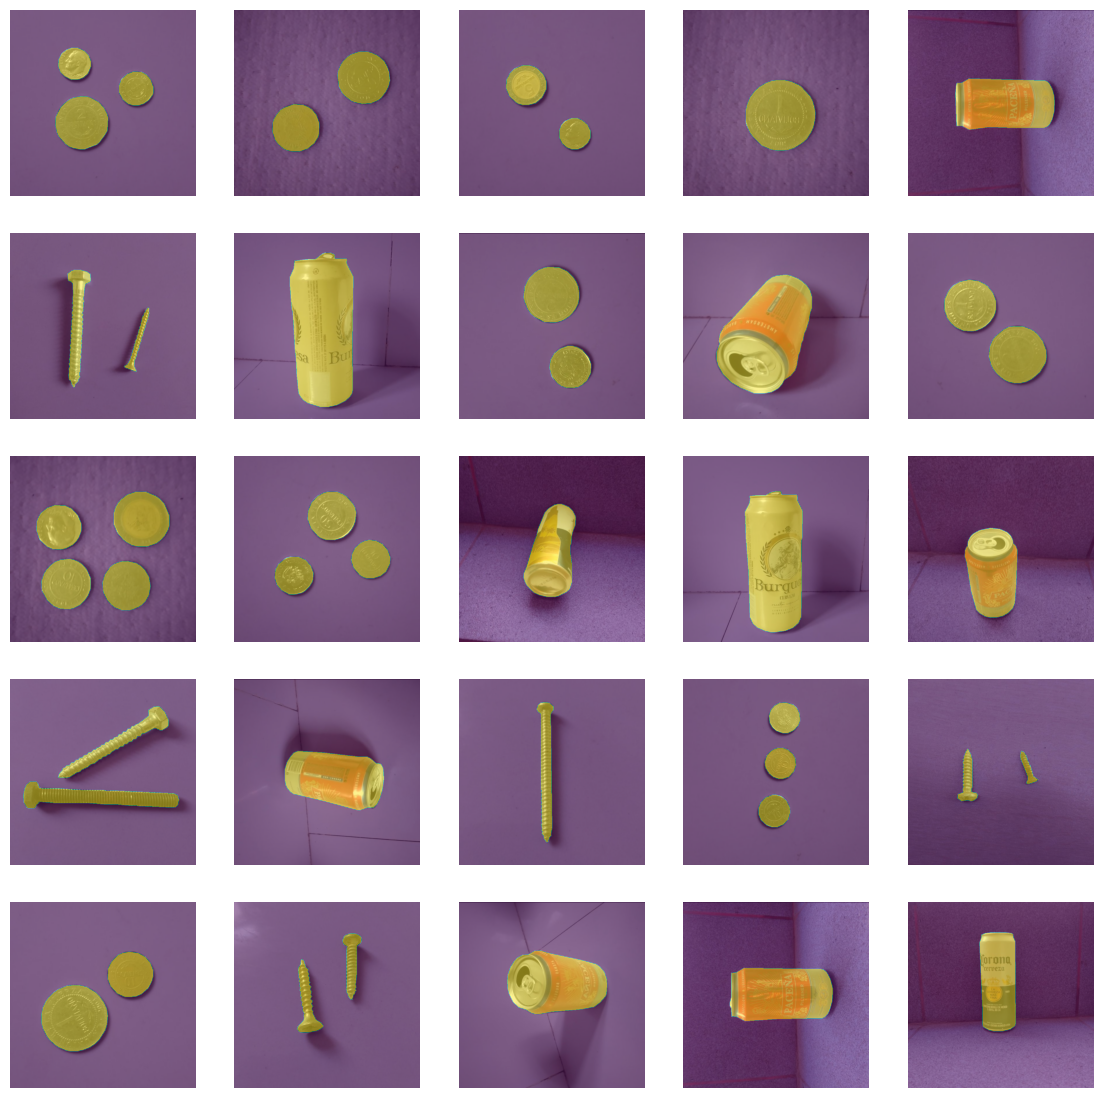

In [9]:
fig, axs = plt.subplots(5,5, figsize=(14,14))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(data_train)-1)
    img, mask, _ = data_train[ix]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
plt.show()

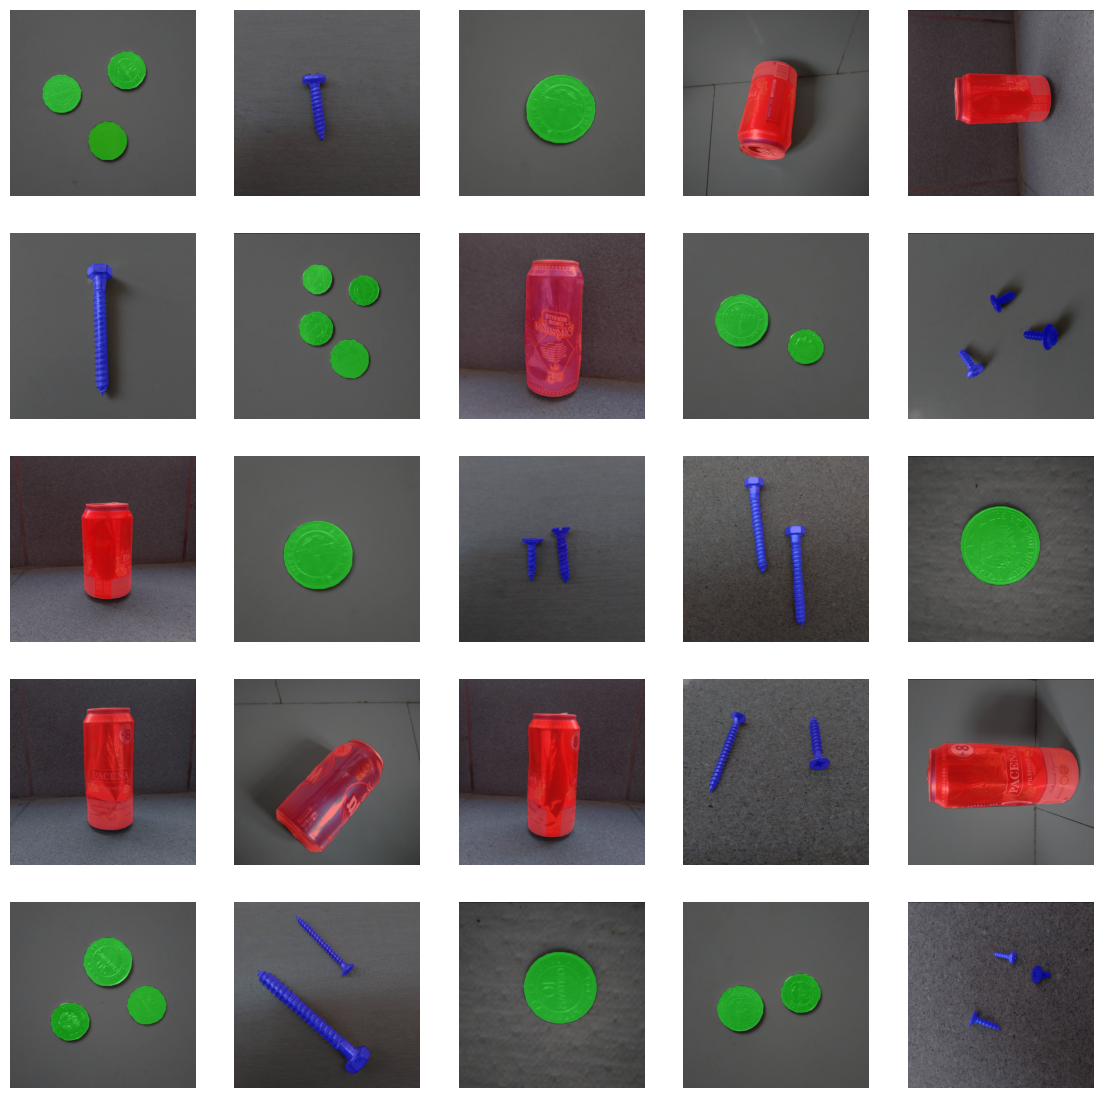

In [10]:
colors = {
    1: [1, 0, 0],
    2: [0, 1, 0],
    3: [0, 0, 1]
}
fig, axs = plt.subplots(5, 5, figsize=(14, 14))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(data_train) - 1)
        img, mask, _ = data_train[ix]
        # Crear una máscara en blanco del mismo tamaño que la imagen
        colored_mask = np.zeros_like(np.transpose(img, (1, 2, 0)))
        # Iterar sobre cada clase y asignar un color diferente
        for class_id, color in colors.items():
            # Asignar el color solo en las regiones donde la clase coincide
            colored_mask[mask == class_id] = color
        # Mostrar la imagen
        ax.imshow(np.transpose(img, (1, 2, 0)))
        # Superponer la máscara coloreada
        ax.imshow(colored_mask, alpha=0.5)
        ax.axis('off')

plt.show()

In [39]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=4, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=4, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=4, shuffle=False, pin_memory=True)
dataloader = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [19]:
imgs, _, mask = next(iter(dataloader['train']))
print('Forma Xi:',imgs.shape,'|',mask.shape)

Forma Xi: torch.Size([4, 3, 640, 640]) | torch.Size([4, 3, 640, 640])


Modelo

In [40]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
model = UNet(in_ch=3)
print((torch.randn((10,3,640,640)).dtype))
output = model(torch.randn((10,3,640,640)))
print('Numero de parametros:',sum(p.numel() for p in model.parameters()))
print(output.shape)

torch.float32
Numero de parametros: 483859
torch.Size([10, 3, 640, 640])


In [41]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [44]:
def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'val_loss': [], 'val_iou': [],'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        train_loss, train_iou = [], []
        model.train()
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, _, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, y)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        model.eval()
        with torch.no_grad():
            val_loss, val_iou = [], []
            bar = tqdm(dataloader['val'])
            for batch in bar:
                X, _, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                ious = iou(y_hat, y)
                val_loss.append(loss.item())
                val_iou.append(ious)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_iou {np.mean(val_iou):.5f}")
            test_loss, test_iou = [], []
            bar = tqdm(dataloader['test'])
            for batch in bar:
                X, _, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                ious = iou(y_hat, y)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        hist['val_loss'].append(np.mean(val_loss))
        hist['val_iou'].append(np.mean(val_iou))
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} val_loss {np.mean(val_loss):.5f} val_iou {np.mean(val_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}\n")
    return hist

In [45]:
model = UNet(in_ch=3)
hist = fit(model, dataloader, epochs=10)

test_loss 0.12444 test_iou 0.56597: 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]



Epoch 1/10 loss 0.27504 iou 0.55705 val_loss 0.13668 val_iou 0.56049 test_loss 0.12444 test_iou 0.56597


test_loss 0.10268 test_iou 0.58005: 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]



Epoch 2/10 loss 0.10932 iou 0.58553 val_loss 0.10862 val_iou 0.58901 test_loss 0.10268 test_iou 0.58005


test_loss 0.08035 test_iou 0.58584: 100%|██████████| 8/8 [00:01<00:00,  6.41it/s]



Epoch 3/10 loss 0.08649 iou 0.59845 val_loss 0.10093 val_iou 0.58963 test_loss 0.08035 test_iou 0.58584


test_loss 0.06064 test_iou 0.62374: 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]



Epoch 4/10 loss 0.07483 iou 0.60732 val_loss 0.06719 val_iou 0.61398 test_loss 0.06064 test_iou 0.62374


test_loss 0.05210 test_iou 0.59399: 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]



Epoch 5/10 loss 0.06493 iou 0.61725 val_loss 0.06512 val_iou 0.60202 test_loss 0.05210 test_iou 0.59399


test_loss 0.04383 test_iou 0.73792: 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]



Epoch 6/10 loss 0.05586 iou 0.62784 val_loss 0.06479 val_iou 0.66494 test_loss 0.04383 test_iou 0.73792


test_loss 0.03223 test_iou 0.71650: 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]



Epoch 7/10 loss 0.04927 iou 0.64451 val_loss 0.05267 val_iou 0.67941 test_loss 0.03223 test_iou 0.71650


test_loss 0.03567 test_iou 0.73534: 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]



Epoch 8/10 loss 0.04685 iou 0.64334 val_loss 0.05377 val_iou 0.75153 test_loss 0.03567 test_iou 0.73534


test_loss 0.04838 test_iou 0.61287: 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]



Epoch 9/10 loss 0.03772 iou 0.66466 val_loss 0.04157 val_iou 0.62891 test_loss 0.04838 test_iou 0.61287


test_loss 0.02805 test_iou 0.69479: 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]


Epoch 10/10 loss 0.03832 iou 0.67179 val_loss 0.04518 val_iou 0.63900 test_loss 0.02805 test_iou 0.69479


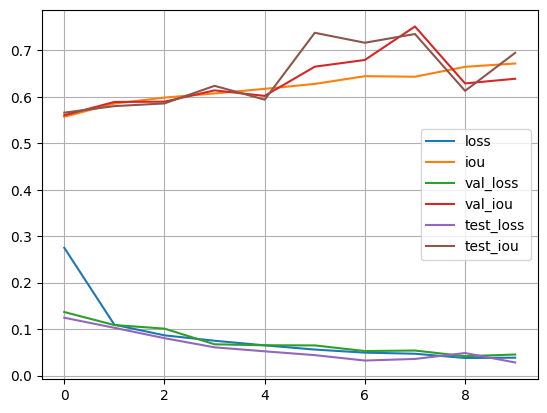

In [46]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

(3, 640, 640)
torch.Size([3, 640, 640])


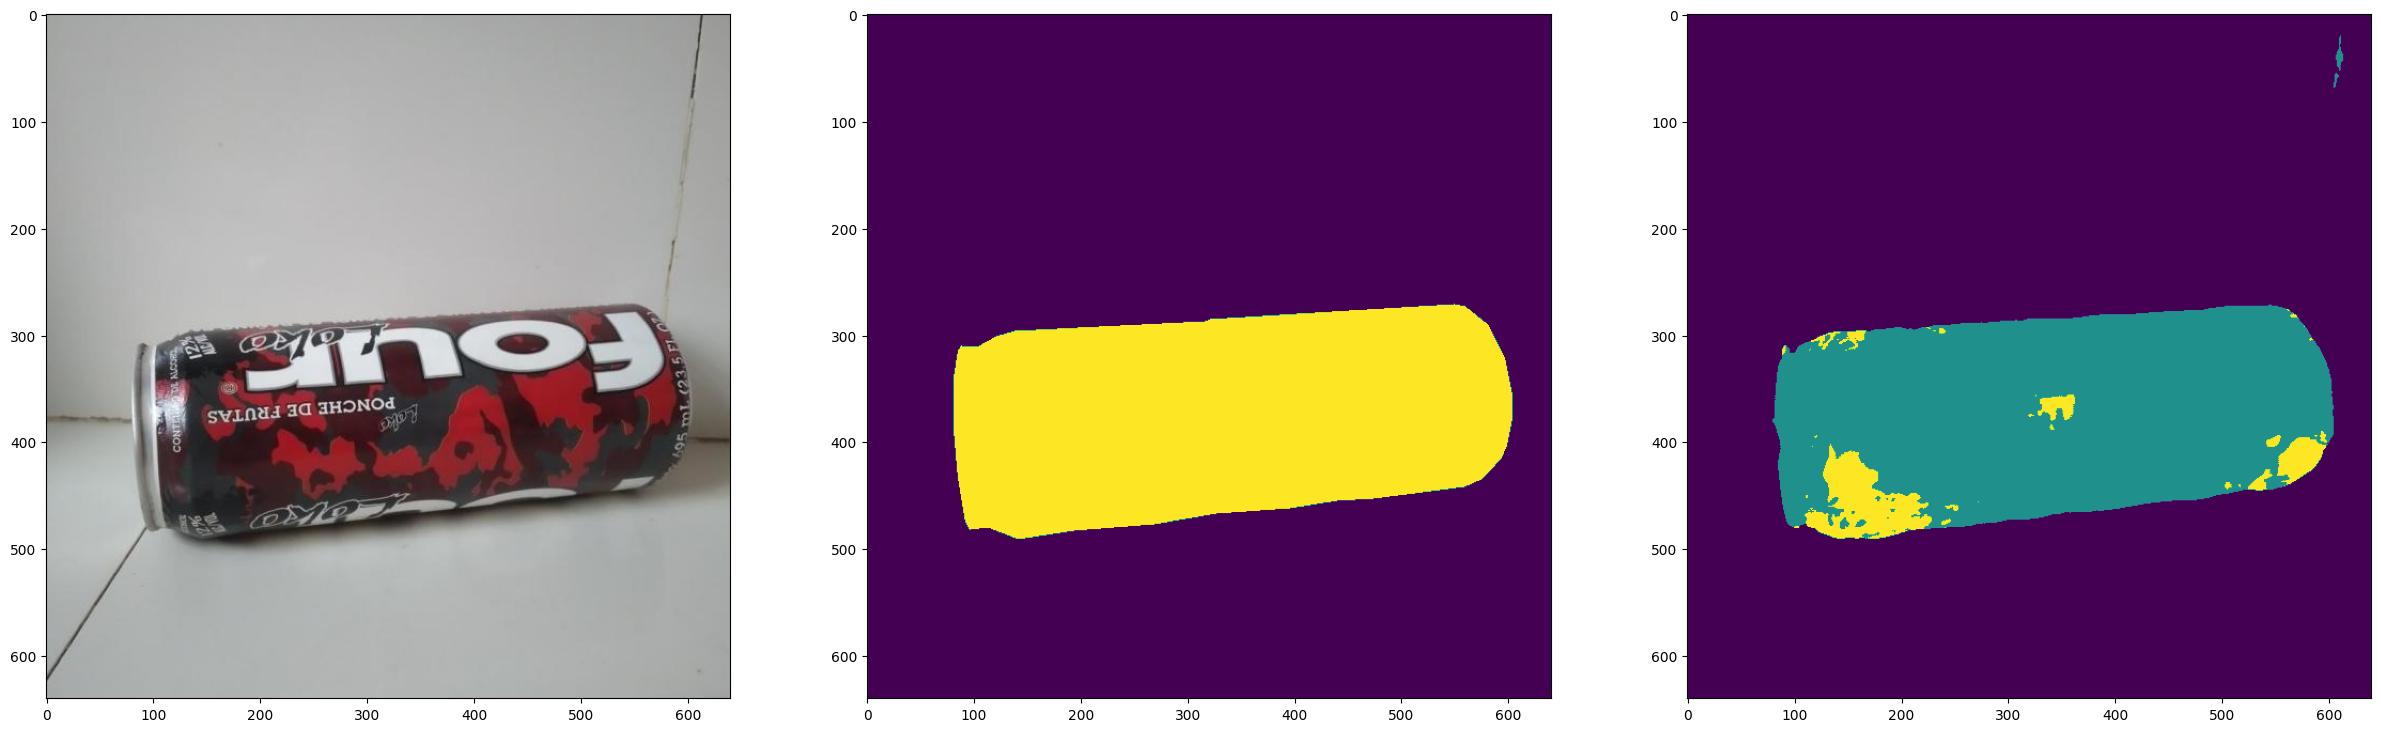

In [48]:
model.eval()
with torch.no_grad():
    ix = random.randint(0, len(data_val)-1)
    img, mask, mask_oh = data_val[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()